# Flood  - Classification Using Logistic Regression

<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 07/11/2016 <br/>
</h3>

# Setup

In [4]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio

from flood_functions import grace_brick_convert_lowres 
from flood_functions import calculate_confusion_matrix_bricks
from flood_functions import calculate_ml_metric_maps
from IPython.display import display, HTML
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%pylab inline
#%matplotlib

Populating the interactive namespace from numpy and matplotlib


In [6]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# Load Data

## GRACE

### Features

In [7]:
# GRACE MASCON-GRI Pickle Files
f = open(dir_python_data+'grace_features_lowres.p', 'rb')
grace_features_dict = pickle.load(f)
f.close()

### Land Mask

In [8]:
# lowres land mask
f = open(dir_python_data + 'grace_land_mask_lowres.p', 'rb')
land_mask = pickle.load(f)
f.close()

land_mask = np.flipud(land_mask.transpose())

## Flood Observatory

### Flood Event Brick

In [9]:
f = open(dir_python_data+'flood_event_brick_lowres.p', 'rb')
flood_event_brick = pickle.load(f)
f.close()

flood_event_brick = flood_event_brick[0]
flood_event_brick = np.flipud(flood_event_brick.transpose(1,0,2))

### Dataframe

In [10]:
df_name = 'df_flood_grace_time_location_features'
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)
print df_flood_grace.shape

(1977, 41)


# Script Variables

In [12]:
tp = len(grace_features_dict['grace_lwe_lowres'])

In [13]:
# features

# grace
feature_brick = grace_features_dict['grace_lwe_rank_lowres']
feature_brick = np.flipud(feature_brick.transpose(1,0,2))
feature_brick_grace = (feature_brick / tp) * 100
# grace no climatology
feature_brick = grace_features_dict['grace_lwe_noClim_rank_lowres']
feature_brick = np.flipud(feature_brick.transpose(1,0,2))
feature_brick_grace_noClim = (feature_brick / tp) * 100
# climatology
feature_brick = grace_features_dict['grace_lwe_clim_rank_lowres']
feature_brick = np.flipud(feature_brick.transpose(1,0,2))
feature_brick_grace_clim = (feature_brick / tp) * 100

In [14]:
# GRACE
label_brick = flood_event_brick
dim = feature_brick.shape
d1 = dim[0]
d2 = dim[1]
tp = dim[2]

# FO
floods = len(df_flood_grace)

# Threshold Classification

In [46]:
y_true = label_brick.ravel()

y_score_grace = feature_brick_grace.ravel()
y_score_grace_noClim = feature_brick_grace_noClim.ravel()
y_score_grace_clim = feature_brick_grace_clim.ravel()

In [47]:
# mask out MASCONs with no flood events
mask = ~np.isnan(y_true)

y_true = y_true[mask]
y_score_grace = y_score_grace[mask]
y_score_grace_noClim = y_score_grace_noClim[mask] 
y_score_grace_clim = y_score_grace_clim[mask] 

## Complete Dataset

In [48]:
# roc curves
fpr_grace, tpr_grace, thresholds_grace =\
    roc_curve(y_true, y_score_grace)
auc_score_grace = roc_auc_score(y_true, y_score_grace)

fpr_grace_noClim, tpr_grace_noClim, thresholds_grace_noClim =\
    roc_curve(y_true, y_score_grace_noClim)
auc_score_grace_noClim = roc_auc_score(y_true, y_score_grace_noClim)    
    
fpr_grace_clim, tpr_grace_clim, thresholds_grace_clim =\
    roc_curve(y_true, y_score_grace_clim)
auc_score_grace_clim = roc_auc_score(y_true, y_score_grace_clim)

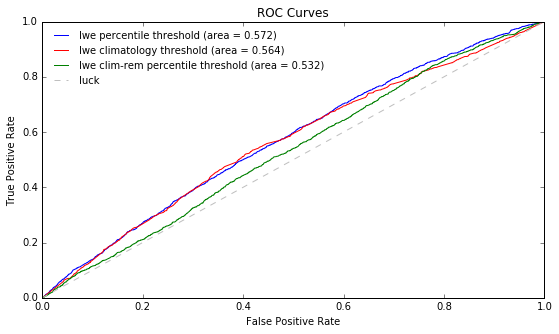

In [49]:
plt.figure(figsize=(9,4.95))

# plot roc curves
plt.plot(fpr_grace, tpr_grace, color='blue',
         label='lwe percentile threshold (area = %0.3f)' % (auc_score_grace))
plt.plot(fpr_grace_clim, tpr_grace_clim, color='red',\
         label='lwe climatology threshold (area = %0.3f)' % (auc_score_grace_clim))
plt.plot(fpr_grace_noClim, tpr_grace_noClim, color='green',\
         label='lwe clim-rem percentile threshold (area = %0.3f)' % (auc_score_grace_noClim))
plt.plot([0,1],[0,1], ls='--', label='luck', color='0.75')



plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='upper left', fontsize='medium', frameon=False)

plt.xlim((0,1))
plt.ylim((0,1))

plt.savefig(dir_figures + 'PP_presentation/roc_threshold',\
            bbox_inches='tight',dpi=350)
plt.show()

## 80% of Dataset

In [50]:
idx_test= int(round(y_true.shape[0] * 0.3) -1)

In [51]:
y_true = y_true[idx_test:-1]
y_score_grace = y_score_grace[idx_test:-1]
y_score_grace_noClim = y_score_grace_noClim[idx_test:-1] 
y_score_grace_clim = y_score_grace_clim[idx_test:-1]

In [52]:
# roc curves
fpr_grace, tpr_grace, thresholds_grace =\
    roc_curve(y_true, y_score_grace)
auc_score_grace = roc_auc_score(y_true, y_score_grace)

fpr_grace_noClim, tpr_grace_noClim, thresholds_grace_noClim =\
    roc_curve(y_true, y_score_grace_noClim)
auc_score_grace_noClim = roc_auc_score(y_true, y_score_grace_noClim)    
    
fpr_grace_clim, tpr_grace_clim, thresholds_grace_clim =\
    roc_curve(y_true, y_score_grace_clim)
auc_score_grace_clim = roc_auc_score(y_true, y_score_grace_clim)

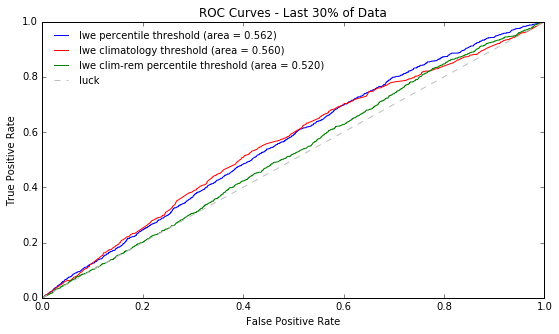

In [54]:
plt.figure(figsize=(9,4.95))

# plot roc curves
plt.plot(fpr_grace, tpr_grace, color='blue',
         label='lwe percentile threshold (area = %0.3f)' % (auc_score_grace))
plt.plot(fpr_grace_clim, tpr_grace_clim, color='red',\
         label='lwe climatology threshold (area = %0.3f)' % (auc_score_grace_clim))
plt.plot(fpr_grace_noClim, tpr_grace_noClim, color='green',\
         label='lwe clim-rem percentile threshold (area = %0.3f)' % (auc_score_grace_noClim))
plt.plot([0,1],[0,1], ls='--', label='luck', color='0.75')

plt.title('ROC Curves - Last 30% of Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='upper left', fontsize='medium', frameon=False)

plt.xlim((0,1))
plt.ylim((0,1))

plt.savefig(dir_figures + 'PP_presentation/roc_threshold',\
            bbox_inches='tight',dpi=350)
plt.show()